# **Adaptive Thresholding Techniques for Data Cleaning on NASA Globe Clouds**
## Anthony Louie
## FIRE398
## Last Modified: May 3, 2022

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount = True)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import os
import urllib
import requests
import PIL
import skimage
import cv2
import colorsys
from PIL import Image
from io import BytesIO
from scipy import stats  
from skimage.color import rgb2hsv
from google.colab.patches import cv2_imshow

This is a library that has some basic image processing functions. I used this library for image resizing for viewing images within the notebook, but calculations and functions are used with the original image dimensions.

In [ ]:
#!pip install imutils
import imutils

## Introduction

[NASA Globe Clouds](https://observer.globe.gov/do-globe-observer/clouds) is a program where NASA has civilians submit 6 images of their current skies, information about cloud cover, current weather conditions, as well as their geographical location. This is a great way of getting a lot of data from all around the world for basically no work. However, these observations are not filtered in any way. While NASA does provide some guidelines to follow for what kind of submission are supposed to be made, it is ultimately up to the observer to see it through. So what happens when there are images that don't meet the guidelines?



For our stream, cloud computing, these images within the database are used for mainly classification models, with the classes of interest being the cloud type. So using images with large obstructions, such as trees or buildings, will affect the training and testing of those models. However, within those submissions the upward image tends to be free of these kinds of obstructions. So if the upward image is representative of the entire observation, then you can use just the upward image without huge loss of information. For this notebook, I took the approach of thresholding the 4 cardinal direction images and the upward image to see if the upward image is similar to the average of the entire observation. And if it is then we can just use the upward image moving forward.

Below is an example of an image from the database that contains numerous obstructions in the form of trees.

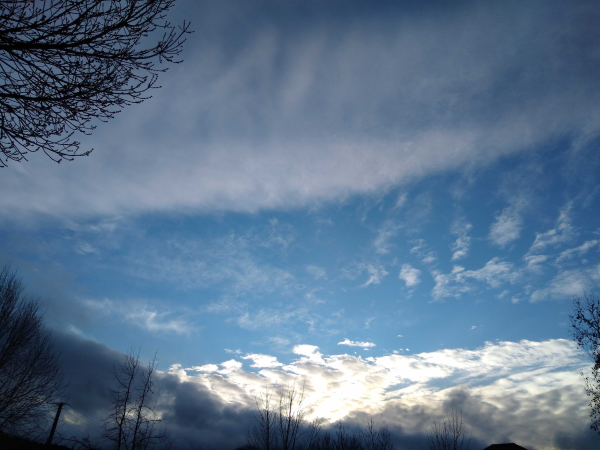

In [ ]:
path1 = r'/content/gdrive/Shareddrives/FIRE-CC/FIRE298/2021/Team MAKE/Images/Training/Ready/image6220.jpg'
original = cv2.imread(path1, -1)
original_rs = imutils.resize(original, height=450)
cv2_imshow(original_rs)

Below is an example of an upward image, notice how there are no obstructions.

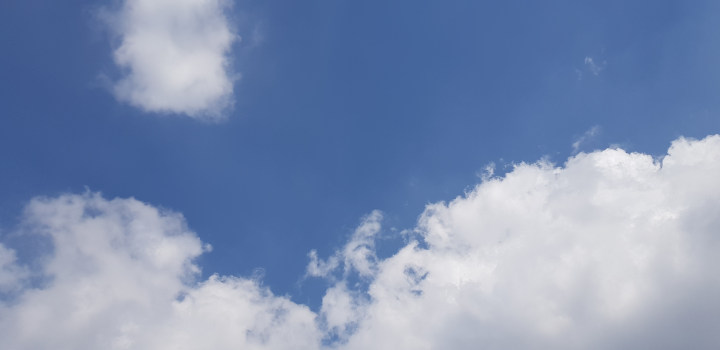

In [ ]:
path2 = r'/content/gdrive/Shareddrives/FIRE-CC/FIRE298/2021/Team MAKE/Images/Training/Ready/image102.jpg'
original2 = cv2.imread(path2, -1)
gray_image2 = cv2.imread(path2, 0)
original2_rs = imutils.resize(original2, height=350)
cv2_imshow(original2_rs)

## Data Scraping and Preprocessing

For the purpose of my research, I am going to use the 2020 observations from NASA Globe Clouds. You can find the download link to this file at this [link](https://observer.globe.gov/get-data/clouds-data) or within the shared drive, look for the Team MAKE folder in the FIRE298 folder. There is also an [API](https://www.globe.gov/globe-data/globe-api) if you want to use that.

Read the csv file's image links. I want the 4 cardinal directions: north, east, west, south, and the upward images. These are the columns that contain links to the actual images. I also take the total cloud cover part of the observations for future use.

In [ ]:
df = pd.read_csv('/content/gdrive/Shareddrives/FIRE-CC/FIRE298/2021/Team MAKE/2020_GLOBE_cloud_data_2021-01-11-v2-0.csv', header=0, usecols=['Ground Image North', 'Ground Image East', 'Ground Image South','Ground Image West', 'Ground Image Up','Total Cloud Cover'], dtype = str)

In [ ]:
df

,Total Cloud Cover,Ground Image North,Ground Image East,Ground Image South,Ground Image West,Ground Image Up
0,broken,-99,-99,-99,-99,-99
1,scattered,-99,-99,-99,-99,-99
2,broken,-99,-99,-99,-99,-99
3,none,-99,-99,-99,-99,-99
4,none,-99,-99,-99,-99,-99
...,...,...,...,...,...,...
250762,none,-99,-99,-99,-99,-99
250763,none,-99,-99,-99,-99,-99
250764,few,https://data.globe.gov/system/photos/2020/12/3...,https://data.globe.gov/system/photos/2020/12/3...,https://data.globe.gov/system/photos/2020/12/3...,https://data.globe.gov/system/photos/2020/12/3...,https://data.globe.gov/system/photos/2020/12/3...
250765,none,-99,-99,-99,-99,-99


Now I clean up the DataFrame since some submissions do not contain image links. NASA does allow you to submit observations without images, but we don't care about those in image classification. I also remove obscured cloud cover images because they mean that the observer did not have a clear shot of images, so there is no meaning to the total cloud fraction. Also since we want to compare the upward image to the other 4 specifically, if any of the images are missing, then we won't use those partially complete observations. 

In [ ]:
# -99 are entries that do not contain image links
df = df[df['Total Cloud Cover'] != 'obscured']
df = df[df['Ground Image North'] != '-99']
df = df[df['Ground Image East'] != '-99']
df = df[df['Ground Image South'] != '-99']
df = df[df['Ground Image West'] != '-99']
df = df[df['Ground Image Up'] != '-99']
df

,Total Cloud Cover,Ground Image North,Ground Image East,Ground Image South,Ground Image West,Ground Image Up
10,broken,https://data.globe.gov/system/photos/2020/01/0...,https://data.globe.gov/system/photos/2020/01/0...,https://data.globe.gov/system/photos/2020/01/0...,https://data.globe.gov/system/photos/2020/01/0...,https://data.globe.gov/system/photos/2020/01/0...
11,none,https://data.globe.gov/system/photos/2020/01/0...,https://data.globe.gov/system/photos/2020/01/0...,https://data.globe.gov/system/photos/2020/01/0...,https://data.globe.gov/system/photos/2020/01/0...,https://data.globe.gov/system/photos/2020/01/0...
15,none,https://data.globe.gov/system/photos/2020/01/0...,https://data.globe.gov/system/photos/2020/01/0...,https://data.globe.gov/system/photos/2020/01/0...,https://data.globe.gov/system/photos/2020/01/0...,https://data.globe.gov/system/photos/2020/01/0...
17,overcast,https://data.globe.gov/system/photos/2020/01/0...,https://data.globe.gov/system/photos/2020/01/0...,https://data.globe.gov/system/photos/2020/01/0...,https://data.globe.gov/system/photos/2020/01/0...,https://data.globe.gov/system/photos/2020/01/0...
22,scattered,https://data.globe.gov/system/photos/2020/01/0...,https://data.globe.gov/system/photos/2020/01/0...,https://data.globe.gov/system/photos/2020/01/0...,https://data.globe.gov/system/photos/2020/01/0...,https://data.globe.gov/system/photos/2020/01/0...
...,...,...,...,...,...,...
250753,none,https://data.globe.gov/system/photos/2020/12/3...,https://data.globe.gov/system/photos/2020/12/3...,https://data.globe.gov/system/photos/2020/12/3...,https://data.globe.gov/system/photos/2020/12/3...,https://data.globe.gov/system/photos/2020/12/3...
250757,overcast,https://data.globe.gov/system/photos/2020/12/3...,https://data.globe.gov/system/photos/2020/12/3...,https://data.globe.gov/system/photos/2020/12/3...,https://data.globe.gov/system/photos/2020/12/3...,https://data.globe.gov/system/photos/2020/12/3...
250758,none,https://data.globe.gov/system/photos/2020/12/3...,https://data.globe.gov/system/photos/2020/12/3...,https://data.globe.gov/system/photos/2020/12/3...,https://data.globe.gov/system/photos/2020/12/3...,https://data.globe.gov/system/photos/2020/12/3...
250764,few,https://data.globe.gov/system/photos/2020/12/3...,https://data.globe.gov/system/photos/2020/12/3...,https://data.globe.gov/system/photos/2020/12/3...,https://data.globe.gov/system/photos/2020/12/3...,https://data.globe.gov/system/photos/2020/12/3...


Just an interesting note, look at how many observations contain all five images when compared to the rest. 

There are $71553/250767$. Which is about $0.285$.

## Methods

I found a useful function from [StackOverflow](https://stackoverflow.com/questions/14134892/convert-image-from-pil-to-opencv-format) that converts an image to its corresponding NumPy array. This is useful in turning images loaded from the web into NumPy arrays for CV2's built in functions. This avoids the need to download the images themselves.

In [ ]:
def convert_from_image_to_cv2(img: Image) -> np.ndarray:
  return cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)

I also made another function based on that code but for converting the BGR colorspace to the HSV colorspace.

In [ ]:
def convert_from_image_to_cv2HSV(img: Image) -> np.ndarray:
  return cv2.cvtColor(np.array(img), cv2.COLOR_BGR2HSV)

Below is a function I made that takes in an image and uses otsu thresholding to try and seperate clouds from the rest of the image. Then return the ratio of cloud pixels, represented by white pixels, to the total number of image pixels to represent cloud coverage in the image.

In [ ]:
def image_threshold(img: np.ndarray):
  h, w, d = img.shape

  # need the image in grayscale
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  # blur to reduce noise
  blur = cv2.GaussianBlur(gray,(5,5),0)

  # otsu thresholding
  ret,otsu = cv2.threshold(blur,108,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

  # get ratio of cloud pixels for image
  number_of_white_pix = np.sum(otsu == 255)
  width, height = otsu.shape
  ratio = number_of_white_pix/(width*height)

  return ratio

NameError: ignored

This is a modified version of the original thresholding function that cuts off the bottom 20% of the image because NASA's specifications are that the bottom portion of the image should not be included in the observer's information submission.

In [ ]:
def image_threshold_cut20(img: np.ndarray):
  h, w, d = img.shape

  #cut image to not include bottom 20 percent
  new_h = int(h*0.8)
  image = img[:new_h,:,:]

  #need the image in grayscale
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

  # blur to reduce noise
  blur = cv2.GaussianBlur(gray,(5,5),0)

  # otsu thresholding
  ret,otsu = cv2.threshold(blur,108,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

  # get ratio of cloud pixels for image
  number_of_white_pix = np.sum(otsu == 255)
  width, height = otsu.shape
  ratio = number_of_white_pix/(width*height)

  return ratio

Below is a modified version of the original thresholding function but we only use the red channel for thresholding.

In [ ]:
def image_threshold_redchannel(img: np.ndarray):
  h, w, d = img.shape

  # red channel
  image = img[:,:,2]

  # blur to reduce noise
  blur = cv2.GaussianBlur(image,(5,5),0)

  # otsu thresholding
  ret,otsu = cv2.threshold(blur,108,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

  # get ratio of cloud pixels for image
  number_of_white_pix = np.sum(otsu == 255)
  width, height = otsu.shape
  ratio = number_of_white_pix/(width*height)

  return ratio

Below is a modified version of the original thresholding function, but here I split the image into 9 parts and apply the thresholding to each part.

In [ ]:
def image_threshold_segmented(img: np.ndarray):
  h, w, d = img.shape

  x_offset = int(h/3)
  y_offset = int(w/3)

  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  # blur to reduce noise
  blur00 = cv2.GaussianBlur(gray[0:x_offset,0:y_offset],(5,5),0)
  blur01 = cv2.GaussianBlur(gray[x_offset:(2*x_offset),0:y_offset],(5,5),0)
  blur02 = cv2.GaussianBlur(gray[(2*x_offset):,0:y_offset],(5,5),0)
  blur10 = cv2.GaussianBlur(gray[0:x_offset,y_offset:(2*y_offset)],(5,5),0)
  blur11 = cv2.GaussianBlur(gray[x_offset:(2*x_offset),y_offset:(2*y_offset)],(5,5),0)
  blur12 = cv2.GaussianBlur(gray[(2*x_offset):,y_offset:(2*y_offset)],(5,5),0)
  blur20 = cv2.GaussianBlur(gray[0:x_offset,(2*y_offset):],(5,5),0)
  blur21 = cv2.GaussianBlur(gray[x_offset:(2*x_offset),(2*y_offset):],(5,5),0)
  blur22 = cv2.GaussianBlur(gray[(2*x_offset):,(2*y_offset):],(5,5),0)

  # otsu thresholding
  ret00,otsu00 = cv2.threshold(blur00,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
  ret01,otsu01 = cv2.threshold(blur01,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
  ret02,otsu02 = cv2.threshold(blur02,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
  ret10,otsu10 = cv2.threshold(blur10,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
  ret11,otsu11 = cv2.threshold(blur11,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
  ret12,otsu12 = cv2.threshold(blur12,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
  ret20,otsu20 = cv2.threshold(blur20,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
  ret21,otsu21 = cv2.threshold(blur21,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
  ret22,otsu22 = cv2.threshold(blur22,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

  # get ratio of cloud pixels for image
  number_of_white_pix = np.sum(otsu00 == 255) + np.sum(otsu01 == 255) + np.sum(otsu02 == 255) + np.sum(otsu10 == 255) + np.sum(otsu11 == 255) + np.sum(otsu12 == 255) + np.sum(otsu20 == 255) + np.sum(otsu21 == 255) + np.sum(otsu22 == 255)
  
  ratio = number_of_white_pix/(w*h)

  return ratio

Below is a modified version of the original thresholding function using the HSV colorspace, in particular we are thresholding the saturation layer of the image.

In [ ]:
def image_thresholding_hsv(img: np.ndarray):
  blur = cv2.GaussianBlur(img[:,:,1],(5,5),0)
  ret,otsu = cv2.threshold(blur,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

  number_of_white_pix = np.sum(otsu == 255)
  width, height = otsu.shape
  ratio = number_of_white_pix/(width*height)
  return ratio

## Exploratory Analysis

For the purposes of visual aid throughout this analysis, I will use the example image mentioned in the Introduction, it is from the 2020 NASA Globe Cloud dataset, that contains high complexity. High complexity means multiple cloud types, different luminosity throughout the cloud, number of clouds themselves, and obstructions in the form of trees.

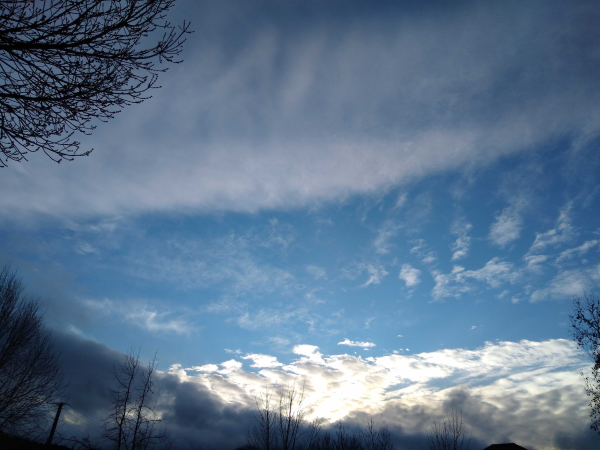

In [ ]:
path1 = r'/content/gdrive/Shareddrives/FIRE-CC/FIRE298/2021/Team MAKE/Images/Training/Ready/image6220.jpg'
original = cv2.imread(path1, -1)
original_rs = imutils.resize(original, height=450)
cv2_imshow(original_rs)

Many of the thresholding function require a grayscale image, a key property of grascale functions are their shapes which is just a 2 dimensional array instead of RGB, BGR, HSV which are 3 dimensional.

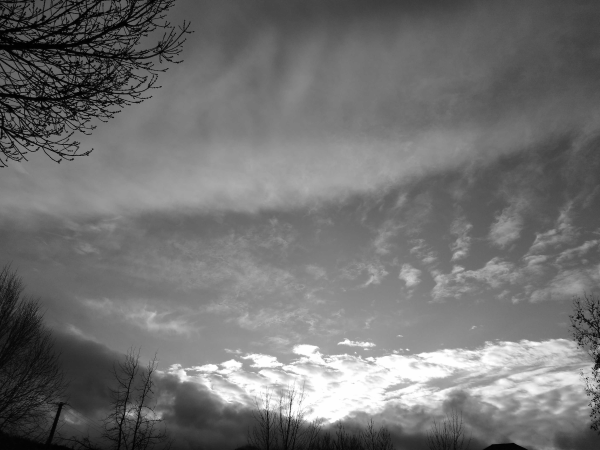

In [ ]:
gray_image = cv2.imread(path1, 0)
gray_image_rs = imutils.resize(gray_image, height=450)
cv2_imshow(gray_image_rs)

This is the corresponding red channel of the image and at a first glance seems to have more contrast between the sky and cloud.

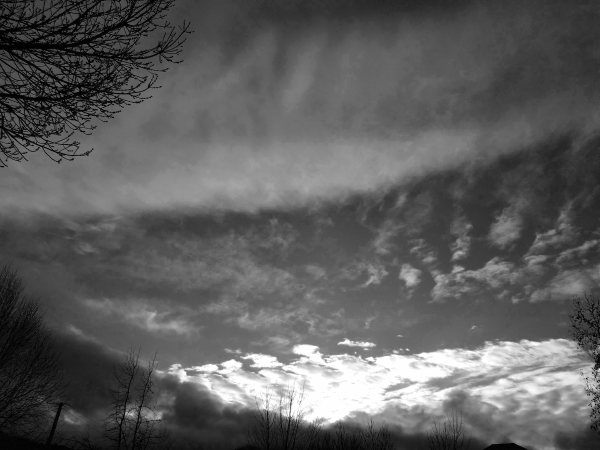

In [ ]:
red_channel = original[:,:,2]
red_channel_rs = imutils.resize(red_channel, height=450)
cv2_imshow(red_channel_rs)

This is the saturation layer of the HSV version of the image. Most of the clouds are darker than the rest of the image, this makes sense since clouds tend to have more luminosity. You can invert the image if you want the cloud portion to be the whiter part which is what I did for the image thresholding function for HSV images later on.

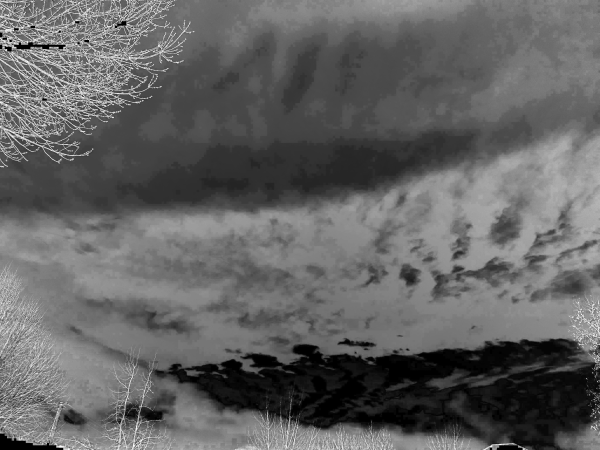

In [ ]:
original_hsv = cv2.cvtColor(original, cv2.COLOR_BGR2HSV)
original_hsv_rs = imutils.resize(original_hsv, height=450)
cv2_imshow(original_hsv_rs[:,:,1])

### Examples of the Functions

These following examples are to show how the functions in the methods section are suppose to work.

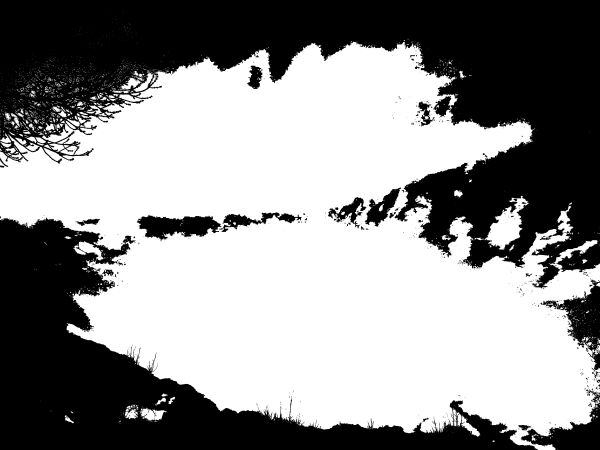

0.5628013610839844


In [ ]:
# grayscale image
blur = cv2.GaussianBlur(gray_image,(5,5),0)
ret,otsu = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
otsu_rs = imutils.resize(otsu, height=450)
cv2_imshow(otsu_rs)
number_of_white_pix = np.sum(otsu == 255)
width, height = otsu.shape
ratio = number_of_white_pix/(width*height)
print(ratio)

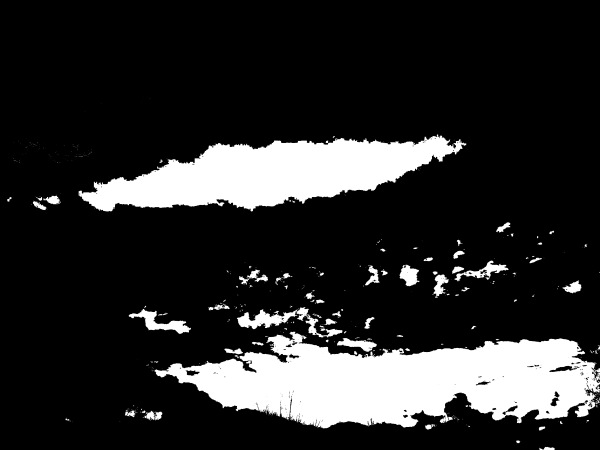

0.17060287793477377


In [ ]:
# red channel
blur = cv2.GaussianBlur(red_channel,(5,5),0)
ret,otsu = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
otsu_rs = imutils.resize(otsu, height=450)
cv2_imshow(otsu_rs)
number_of_white_pix = np.sum(otsu == 255)
width, height = otsu.shape
ratio = number_of_white_pix/(width*height)
print(ratio)

Next, let's try to figure out a way to utilize otsu thresholding so we can better distinguish cloud from sky and obstuctions. Try seperating the image into 9 parts and run thresholding on each segment.

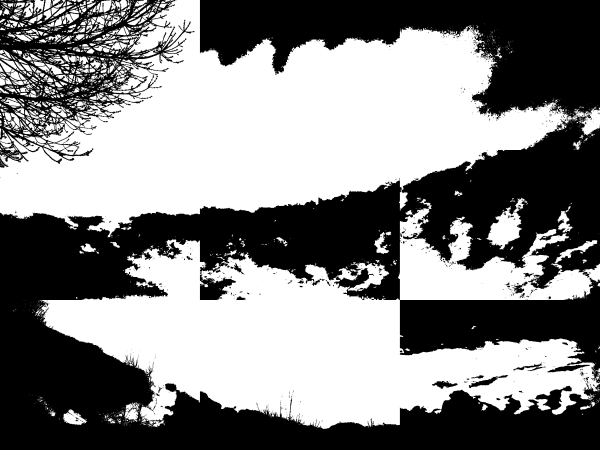

0.5206317901611328


In [ ]:
# Grayscale segmentation 3x3
h, w, d = original.shape

x_offset = int(h/3)
y_offset = int(w/3)

gray = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)

# blur to reduce noise
blur00 = cv2.GaussianBlur(gray[0:x_offset,0:y_offset],(5,5),0)
blur01 = cv2.GaussianBlur(gray[x_offset:(2*x_offset),0:y_offset],(5,5),0)
blur02 = cv2.GaussianBlur(gray[(2*x_offset):,0:y_offset],(5,5),0)
blur10 = cv2.GaussianBlur(gray[0:x_offset,y_offset:(2*y_offset)],(5,5),0)
blur11 = cv2.GaussianBlur(gray[x_offset:(2*x_offset),y_offset:(2*y_offset)],(5,5),0)
blur12 = cv2.GaussianBlur(gray[(2*x_offset):,y_offset:(2*y_offset)],(5,5),0)
blur20 = cv2.GaussianBlur(gray[0:x_offset,(2*y_offset):],(5,5),0)
blur21 = cv2.GaussianBlur(gray[x_offset:(2*x_offset),(2*y_offset):],(5,5),0)
blur22 = cv2.GaussianBlur(gray[(2*x_offset):,(2*y_offset):],(5,5),0)

# otsu thresholding
ret00,otsu00 = cv2.threshold(blur00,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
ret01,otsu01 = cv2.threshold(blur01,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
ret02,otsu02 = cv2.threshold(blur02,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
ret10,otsu10 = cv2.threshold(blur10,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
ret11,otsu11 = cv2.threshold(blur11,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
ret12,otsu12 = cv2.threshold(blur12,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
ret20,otsu20 = cv2.threshold(blur20,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
ret21,otsu21 = cv2.threshold(blur21,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
ret22,otsu22 = cv2.threshold(blur22,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

# get ratio of cloud pixels for image
number_of_white_pix = np.sum(otsu00 == 255) + np.sum(otsu01 == 255) + np.sum(otsu02 == 255) + np.sum(otsu10 == 255) + np.sum(otsu11 == 255) + np.sum(otsu12 == 255) + np.sum(otsu20 == 255) + np.sum(otsu21 == 255) + np.sum(otsu22 == 255)
width, height = otsu.shape
ratio = number_of_white_pix/(width*height)

# Concatenate the 9 images back into one
otsu0 = np.concatenate((otsu00, otsu01, otsu02), axis=0)
otsu1 = np.concatenate((otsu10, otsu11, otsu12), axis=0)
otsu2 = np.concatenate((otsu20, otsu21, otsu22), axis=0)
otsu_image = np.concatenate((otsu0, otsu1, otsu2), axis=1)
otsu_image_rs = imutils.resize(otsu_image, height=450)
cv2_imshow(otsu_image_rs)

# cloud cover percentage
print(ratio)

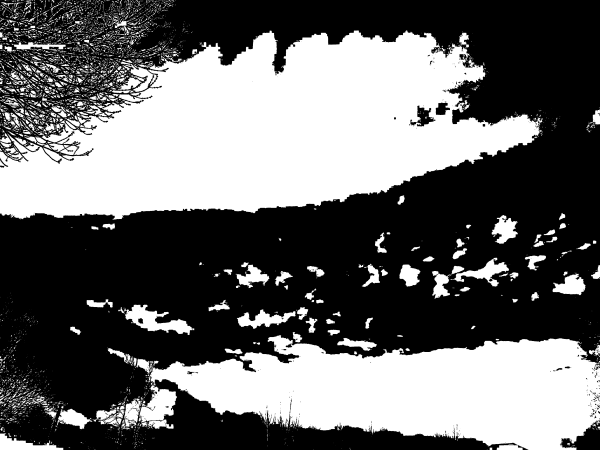

In [ ]:
# saturation layer of HSV
blur = cv2.GaussianBlur(original_hsv[:,:,1],(5,5),0)
ret,otsu = cv2.threshold(blur,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
otsu_rs = imutils.resize(otsu, height=450)
cv2_imshow(otsu_rs)

This is a sperate function that uses surrounding pixels to generate a local threshold for a pixel. Here I use 89 pixel radius with a constant of 5. The input is a grayscale image. I was going to try to use this, but it only seems to be able to identify obstructions. I do not use this going forward, but I wanted to mention this. If any future work wants to do work with just the obsrtuctions in the image, then this would be a good place to start.

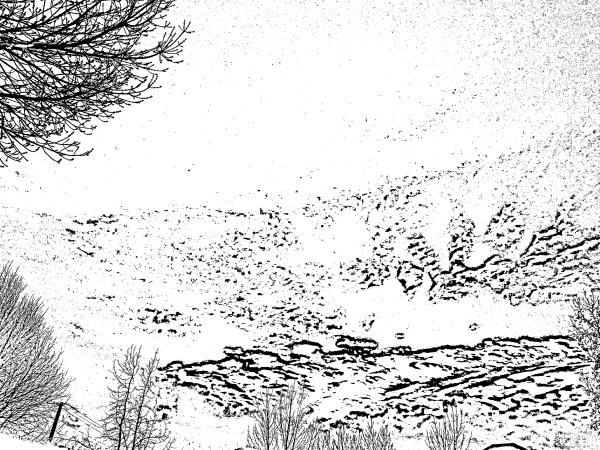

0.8557915687561035


In [ ]:
adaptive = cv2.adaptiveThreshold(red_channel,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,89,5)
adaptive_rs = imutils.resize(adaptive, height=450)
cv2_imshow(adaptive_rs)

number_of_white_pix = np.sum(adaptive == 255)
width, height = adaptive.shape
ratio = number_of_white_pix/(width*height)

print(ratio)

# Data Anaylsis: Getting Percentages

Now that we have seen examples of how the various functions work. Let's apply these functions to mutiple observations and see if there are any trends.

This is a function I used to download metrics from images in the DataFrame from the beginning.

NOTE: I changed the contents of this function when when deciding what colorspace conversion and thresholding function to use.

In [ ]:
def cloud_cover(frame):
  from tqdm import tqdm # just gives a visual progress bar
  i = 0
  up_p = np.zeros(100)
  avg_p = np.zeros(100)

  for index, row in tqdm(frame.iterrows()):
    north = row['Ground Image North']
    east = row['Ground Image East']
    south = row['Ground Image South']
    west = row['Ground Image West']
    up = row['Ground Image Up']

    north_response = requests.get(north)
    north_image = Image.open(BytesIO(north_response.content))
    north_cv = convert_from_image_to_cv2(north_image)
    north_percentage = image_threshold(north_cv)

    east_response = requests.get(east)
    east_image = Image.open(BytesIO(east_response.content))
    east_cv = convert_from_image_to_cv2(east_image)
    east_percentage = image_threshold(east_cv)

    south_response = requests.get(south)
    south_image = Image.open(BytesIO(south_response.content))
    south_cv = convert_from_image_to_cv2(south_image)
    south_percentage = image_threshold(south_cv)

    west_response = requests.get(west)
    west_image = Image.open(BytesIO(west_response.content))
    west_cv = convert_from_image_to_cv2(west_image)
    west_percentage = image_threshold(west_cv)

    up_response = requests.get(up)
    up_image = Image.open(BytesIO(up_response.content))
    up_cv = convert_from_image_to_cv2(up_image)
    up_percentage = image_threshold(up_cv)
  
    total_percentage = (north_percentage + east_percentage + south_percentage + west_percentage + up_percentage)/5
  
    up_p[i] = up_percentage
    avg_p[i] = total_percentage
    i = i + 1

  return up_p, avg_p

First I get a random sample, 100 images for each total cloud cover category (600 total), of the DataFrame to run analysis on the total cloud cover categories. It would take too long to run the code on all entries, but if you wanted to just run cloud_cover() with the whole DataFrame as the input.

In [ ]:
# see how many categories there are
print(df['Total Cloud Cover'].unique())

['broken' 'none' 'overcast' 'scattered' 'few' 'isolated' '-99']


In [ ]:
# I seed the random state in the sampling to get the same images when running the different thresholding functions
none = (df[df['Total Cloud Cover'] == 'none']).sample(n=100, random_state=398)
few = (df[df['Total Cloud Cover'] == 'few']).sample(n=100, random_state=398)
isolated = (df[df['Total Cloud Cover'] == 'isolated']).sample(n=100, random_state=398)
scattered = (df[df['Total Cloud Cover'] == 'scattered']).sample(n=100, random_state=398)
broken = (df[df['Total Cloud Cover'] == 'broken']).sample(n=100, random_state=398)
overcast = (df[df['Total Cloud Cover'] == 'overcast']).sample(n=100, random_state=398)

This function just organizes all colorspace conversions and thresholding functions into a one liner for the following prompt.

In [ ]:
def wanna_cry(response):
  if response == True:
    #none
    none_up, none_avg = cloud_cover(none)
    np.save('/content/gdrive/Shareddrives/FIRE-CC/Peer Mentors/2022/Anthony/hsv/none_up.npy', none_up)
    np.save('/content/gdrive/Shareddrives/FIRE-CC/Peer Mentors/2022/Anthony/hsv/none_avg.npy', none_avg)

    #few
    few_up, few_avg = cloud_cover(few)
    np.save('/content/gdrive/Shareddrives/FIRE-CC/Peer Mentors/2022/Anthony/hsv/few_up.npy', few_up)
    np.save('/content/gdrive/Shareddrives/FIRE-CC/Peer Mentors/2022/Anthony/hsv/few_avg.npy', few_avg)

    #isolated
    isolated_up, isolated_avg = cloud_cover(isolated)
    np.save('/content/gdrive/Shareddrives/FIRE-CC/Peer Mentors/2022/Anthony/hsv/isolated_up.npy', isolated_up)
    np.save('/content/gdrive/Shareddrives/FIRE-CC/Peer Mentors/2022/Anthony/hsv/isolated_avg.npy', isolated_avg)

    #scattered
    scattered_up, scattered_avg = cloud_cover(scattered)
    np.save('/content/gdrive/Shareddrives/FIRE-CC/Peer Mentors/2022/Anthony/hsv/scattered_up.npy', scattered_up)
    np.save('/content/gdrive/Shareddrives/FIRE-CC/Peer Mentors/2022/Anthony/hsv/scattered_avg.npy', scattered_avg)

    #broken
    broken_up, broken_avg = cloud_cover(broken)
    np.save('/content/gdrive/Shareddrives/FIRE-CC/Peer Mentors/2022/Anthony/hsv/broken_up.npy', broken_up)
    np.save('/content/gdrive/Shareddrives/FIRE-CC/Peer Mentors/2022/Anthony/hsv/broken_avg.npy', broken_avg)

    #overcast
    overcast_up, overcast_avg = cloud_cover(overcast)
    np.save('/content/gdrive/Shareddrives/FIRE-CC/Peer Mentors/2022/Anthony/hsv/overcast_up.npy', overcast_up)
    np.save('/content/gdrive/Shareddrives/FIRE-CC/Peer Mentors/2022/Anthony/hsv/overcast_avg.npy', overcast_avg)

Prompt the user if they want to download more data. This is here so if you run the notebook, it does not automatically download things again. 

If you do choose to redownload data maybe using a different seed, make sure that the colorspace conversion and thresholding functions are the ones you want. And update the paths to where you want to save the data and its name.

In [ ]:
val = input('Enter \'yes\' if you want to redownload the percentages: ')
if val == 'yes':
  wanna_cry(True)

Enter 'yes' if you want to redownload the percentages: no


Since we download the data to drive, we just need to load the saved values from drive.

In [ ]:
# Cut data
none_up = np.load('/content/gdrive/Shareddrives/FIRE-CC/Peer Mentors/2022/Anthony/cut_data/none_up.npy')
none_avg = np.load('/content/gdrive/Shareddrives/FIRE-CC/Peer Mentors/2022/Anthony/cut_data/none_avg.npy')

few_up = np.load('/content/gdrive/Shareddrives/FIRE-CC/Peer Mentors/2022/Anthony/cut_data/few_up.npy')
few_avg = np.load('/content/gdrive/Shareddrives/FIRE-CC/Peer Mentors/2022/Anthony/cut_data/few_avg.npy')

isolated_up = np.load('/content/gdrive/Shareddrives/FIRE-CC/Peer Mentors/2022/Anthony/cut_data/isolated_up.npy')
isolated_avg = np.load('/content/gdrive/Shareddrives/FIRE-CC/Peer Mentors/2022/Anthony/cut_data/isolated_avg.npy')

scattered_up = np.load('/content/gdrive/Shareddrives/FIRE-CC/Peer Mentors/2022/Anthony/cut_data/scattered_up.npy')
scattered_avg = np.load('/content/gdrive/Shareddrives/FIRE-CC/Peer Mentors/2022/Anthony/cut_data/scattered_avg.npy')

broken_up = np.load('/content/gdrive/Shareddrives/FIRE-CC/Peer Mentors/2022/Anthony/cut_data/broken_up.npy')
broken_avg = np.load('/content/gdrive/Shareddrives/FIRE-CC/Peer Mentors/2022/Anthony/cut_data/broken_avg.npy')

overcast_up = np.load('/content/gdrive/Shareddrives/FIRE-CC/Peer Mentors/2022/Anthony/cut_data/overcast_up.npy')
overcast_avg = np.load('/content/gdrive/Shareddrives/FIRE-CC/Peer Mentors/2022/Anthony/cut_data/overcast_avg.npy')

# Uncut Data
none_up_uncut = np.load('/content/gdrive/Shareddrives/FIRE-CC/Peer Mentors/2022/Anthony/uncut_data/none_up.npy')
none_avg_uncut = np.load('/content/gdrive/Shareddrives/FIRE-CC/Peer Mentors/2022/Anthony/uncut_data/none_avg.npy')

few_up_uncut = np.load('/content/gdrive/Shareddrives/FIRE-CC/Peer Mentors/2022/Anthony/uncut_data/few_up.npy')
few_avg_uncut = np.load('/content/gdrive/Shareddrives/FIRE-CC/Peer Mentors/2022/Anthony/uncut_data/few_avg.npy')

isolated_up_uncut = np.load('/content/gdrive/Shareddrives/FIRE-CC/Peer Mentors/2022/Anthony/uncut_data/isolated_up.npy')
isolated_avg_uncut = np.load('/content/gdrive/Shareddrives/FIRE-CC/Peer Mentors/2022/Anthony/uncut_data/isolated_avg.npy')

scattered_up_uncut = np.load('/content/gdrive/Shareddrives/FIRE-CC/Peer Mentors/2022/Anthony/uncut_data/scattered_up.npy')
scattered_avg_uncut = np.load('/content/gdrive/Shareddrives/FIRE-CC/Peer Mentors/2022/Anthony/uncut_data/scattered_avg.npy')

broken_up_uncut = np.load('/content/gdrive/Shareddrives/FIRE-CC/Peer Mentors/2022/Anthony/uncut_data/broken_up.npy')
broken_avg_uncut = np.load('/content/gdrive/Shareddrives/FIRE-CC/Peer Mentors/2022/Anthony/uncut_data/broken_avg.npy')

overcast_up_uncut = np.load('/content/gdrive/Shareddrives/FIRE-CC/Peer Mentors/2022/Anthony/uncut_data/overcast_up.npy')
overcast_avg_uncut = np.load('/content/gdrive/Shareddrives/FIRE-CC/Peer Mentors/2022/Anthony/uncut_data/overcast_avg.npy')

# Blue Channel Data
none_up_red = np.load('/content/gdrive/Shareddrives/FIRE-CC/Peer Mentors/2022/Anthony/red_data/none_up.npy')
none_avg_red = np.load('/content/gdrive/Shareddrives/FIRE-CC/Peer Mentors/2022/Anthony/red_data/none_avg.npy')

few_up_red = np.load('/content/gdrive/Shareddrives/FIRE-CC/Peer Mentors/2022/Anthony/red_data/few_up.npy')
few_avg_red = np.load('/content/gdrive/Shareddrives/FIRE-CC/Peer Mentors/2022/Anthony/red_data/few_avg.npy')

isolated_up_red = np.load('/content/gdrive/Shareddrives/FIRE-CC/Peer Mentors/2022/Anthony/red_data/isolated_up.npy')
isolated_avg_red = np.load('/content/gdrive/Shareddrives/FIRE-CC/Peer Mentors/2022/Anthony/red_data/isolated_avg.npy')

scattered_up_red = np.load('/content/gdrive/Shareddrives/FIRE-CC/Peer Mentors/2022/Anthony/red_data/scattered_up.npy')
scattered_avg_red = np.load('/content/gdrive/Shareddrives/FIRE-CC/Peer Mentors/2022/Anthony/red_data/scattered_avg.npy')

broken_up_red = np.load('/content/gdrive/Shareddrives/FIRE-CC/Peer Mentors/2022/Anthony/red_data/broken_up.npy')
broken_avg_red = np.load('/content/gdrive/Shareddrives/FIRE-CC/Peer Mentors/2022/Anthony/red_data/broken_avg.npy')

overcast_up_red = np.load('/content/gdrive/Shareddrives/FIRE-CC/Peer Mentors/2022/Anthony/red_data/overcast_up.npy')
overcast_avg_red = np.load('/content/gdrive/Shareddrives/FIRE-CC/Peer Mentors/2022/Anthony/red_data/overcast_avg.npy')

# 3x3 Segmentated Data
none_up_seg = np.load('/content/gdrive/Shareddrives/FIRE-CC/Peer Mentors/2022/Anthony/gray_segmentated/none_up.npy')
none_avg_seg = np.load('/content/gdrive/Shareddrives/FIRE-CC/Peer Mentors/2022/Anthony/gray_segmentated/none_avg.npy')

few_up_seg = np.load('/content/gdrive/Shareddrives/FIRE-CC/Peer Mentors/2022/Anthony/gray_segmentated/few_up.npy')
few_avg_seg = np.load('/content/gdrive/Shareddrives/FIRE-CC/Peer Mentors/2022/Anthony/gray_segmentated/few_avg.npy')

isolated_up_seg = np.load('/content/gdrive/Shareddrives/FIRE-CC/Peer Mentors/2022/Anthony/gray_segmentated/isolated_up.npy')
isolated_avg_seg = np.load('/content/gdrive/Shareddrives/FIRE-CC/Peer Mentors/2022/Anthony/gray_segmentated/isolated_avg.npy')

scattered_up_seg = np.load('/content/gdrive/Shareddrives/FIRE-CC/Peer Mentors/2022/Anthony/gray_segmentated/scattered_up.npy')
scattered_avg_seg = np.load('/content/gdrive/Shareddrives/FIRE-CC/Peer Mentors/2022/Anthony/gray_segmentated/scattered_avg.npy')

broken_up_seg = np.load('/content/gdrive/Shareddrives/FIRE-CC/Peer Mentors/2022/Anthony/gray_segmentated/broken_up.npy')
broken_avg_seg = np.load('/content/gdrive/Shareddrives/FIRE-CC/Peer Mentors/2022/Anthony/gray_segmentated/broken_avg.npy')

overcast_up_seg = np.load('/content/gdrive/Shareddrives/FIRE-CC/Peer Mentors/2022/Anthony/gray_segmentated/overcast_up.npy')
overcast_avg_seg = np.load('/content/gdrive/Shareddrives/FIRE-CC/Peer Mentors/2022/Anthony/gray_segmentated/overcast_avg.npy')

# HSV Saturation Data
none_up_hsv = np.load('/content/gdrive/Shareddrives/FIRE-CC/Peer Mentors/2022/Anthony/hsv/none_up.npy')
none_avg_hsv = np.load('/content/gdrive/Shareddrives/FIRE-CC/Peer Mentors/2022/Anthony/hsv/none_avg.npy')

few_up_hsv = np.load('/content/gdrive/Shareddrives/FIRE-CC/Peer Mentors/2022/Anthony/hsv/few_up.npy')
few_avg_hsv = np.load('/content/gdrive/Shareddrives/FIRE-CC/Peer Mentors/2022/Anthony/hsv/few_avg.npy')

isolated_up_hsv = np.load('/content/gdrive/Shareddrives/FIRE-CC/Peer Mentors/2022/Anthony/hsv/isolated_up.npy')
isolated_avg_hsv = np.load('/content/gdrive/Shareddrives/FIRE-CC/Peer Mentors/2022/Anthony/hsv/isolated_avg.npy')

scattered_up_hsv = np.load('/content/gdrive/Shareddrives/FIRE-CC/Peer Mentors/2022/Anthony/hsv/scattered_up.npy')
scattered_avg_hsv = np.load('/content/gdrive/Shareddrives/FIRE-CC/Peer Mentors/2022/Anthony/hsv/scattered_avg.npy')

broken_up_hsv = np.load('/content/gdrive/Shareddrives/FIRE-CC/Peer Mentors/2022/Anthony/hsv/broken_up.npy')
broken_avg_hsv = np.load('/content/gdrive/Shareddrives/FIRE-CC/Peer Mentors/2022/Anthony/hsv/broken_avg.npy')

overcast_up_hsv = np.load('/content/gdrive/Shareddrives/FIRE-CC/Peer Mentors/2022/Anthony/hsv/overcast_up.npy')
overcast_avg_hsv = np.load('/content/gdrive/Shareddrives/FIRE-CC/Peer Mentors/2022/Anthony/hsv/overcast_avg.npy')

## Analysis of Data

For these scatter plots, to see if the upward image is representative of the observation, they should lie near the diagonal line. This would mean that upward cloud fraction percentage is close to the average cloud fraction for all images in the observation. 

NOTE: The percentages are gathered using the different thresholding functions.

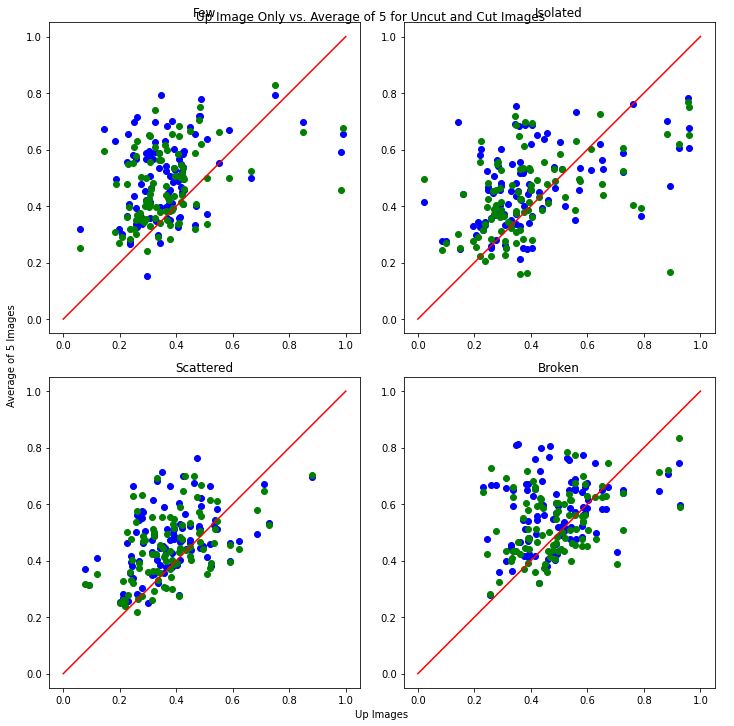

In [ ]:
x = np.linspace(0,1,100)
y = x

fig, axs = plt.subplots(2, 2, figsize=(10,10))
axs[0, 0].scatter(few_up_uncut, few_avg_uncut, c='b', marker='o', label='uncut')
axs[0, 0].scatter(few_up_uncut, few_avg, c='g')
axs[0, 0].set_title('Few')
axs[0, 0].plot(x, y,'-r')
axs[1, 0].scatter(scattered_up_uncut, scattered_avg_uncut, c='b')
axs[1, 0].scatter(scattered_up_uncut, scattered_avg, c='g')
axs[1, 0].set_title('Scattered')
axs[1, 0].plot(x, y,'-r')
axs[0, 1].scatter(isolated_up_uncut, isolated_avg_uncut, c='b')
axs[0, 1].scatter(isolated_up_uncut, isolated_avg, c='g')
axs[0, 1].set_title('Isolated')
axs[0, 1].plot(x, y,'-r')
axs[1, 1].scatter(broken_up_uncut, broken_avg_uncut, c='b')
axs[1, 1].scatter(broken_up_uncut, broken_avg, c='g')
axs[1, 1].set_title('Broken')
axs[1, 1].plot(x, y,'-r')

fig.tight_layout()
axs[0, 0].set_aspect('equal', adjustable='box')
axs[0, 1].set_aspect('equal', adjustable='box')
axs[1, 0].set_aspect('equal', adjustable='box')
axs[1, 1].set_aspect('equal', adjustable='box')
plt.axis('square')

fig.add_subplot(111, frame_on=False)
plt.tick_params(labelcolor="none", bottom=False, left=False)

plt.suptitle('Up Image Only vs. Average of 5 for Uncut and Cut Images')
plt.xlabel('Up Images')
plt.ylabel('Average of 5 Images')
plt.show()

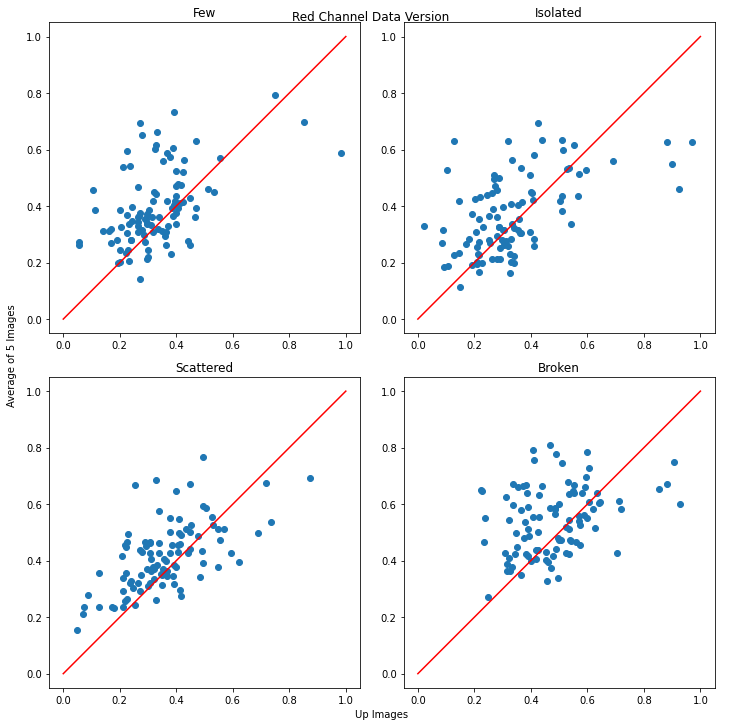

In [ ]:
# Red channel data

x = np.linspace(0,1,100)
y = x

fig, axs = plt.subplots(2, 2, figsize=(10,10))
axs[0, 0].scatter(few_up_red, few_avg_red)
axs[0, 0].set_title('Few')
axs[0, 0].plot(x, y,'-r')
axs[1, 0].scatter(scattered_up_red, scattered_avg_red)
axs[1, 0].set_title('Scattered')
axs[1, 0].plot(x, y,'-r')
axs[0, 1].scatter(isolated_up_red, isolated_avg_red)
axs[0, 1].set_title('Isolated')
axs[0, 1].plot(x, y,'-r')
axs[1, 1].scatter(broken_up_red, broken_avg_red)
axs[1, 1].set_title('Broken')
axs[1, 1].plot(x, y,'-r')

fig.tight_layout()
axs[0, 0].set_aspect('equal', adjustable='box')
axs[0, 1].set_aspect('equal', adjustable='box')
axs[1, 0].set_aspect('equal', adjustable='box')
axs[1, 1].set_aspect('equal', adjustable='box')
plt.axis('square')

fig.add_subplot(111, frame_on=False)
plt.tick_params(labelcolor="none", bottom=False, left=False)

plt.suptitle('Red Channel Data Version')
plt.xlabel('Up Images')
plt.ylabel('Average of 5 Images')
plt.show()

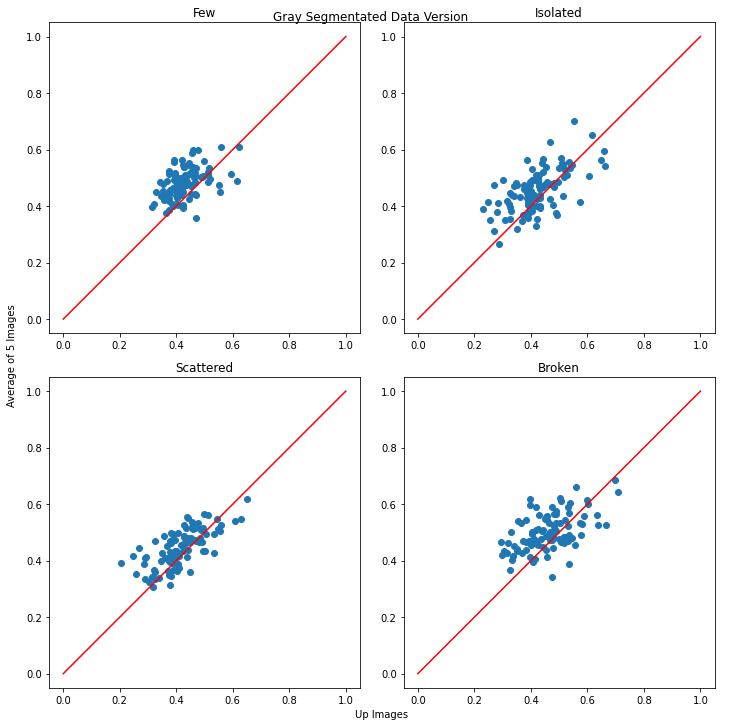

In [ ]:
# Segmentated gray channel data

x = np.linspace(0,1,100)
y = x

fig, axs = plt.subplots(2, 2, figsize=(10,10))
axs[0, 0].scatter(few_up_seg, few_avg_seg)
axs[0, 0].set_title('Few')
axs[0, 0].plot(x, y,'-r')
axs[1, 0].scatter(scattered_up_seg, scattered_avg_seg)
axs[1, 0].set_title('Scattered')
axs[1, 0].plot(x, y,'-r')
axs[0, 1].scatter(isolated_up_seg, isolated_avg_seg)
axs[0, 1].set_title('Isolated')
axs[0, 1].plot(x, y,'-r')
axs[1, 1].scatter(broken_up_seg, broken_avg_seg)
axs[1, 1].set_title('Broken')
axs[1, 1].plot(x, y,'-r')

fig.tight_layout()
axs[0, 0].set_aspect('equal', adjustable='box')
axs[0, 1].set_aspect('equal', adjustable='box')
axs[1, 0].set_aspect('equal', adjustable='box')
axs[1, 1].set_aspect('equal', adjustable='box')
plt.axis('square')

fig.add_subplot(111, frame_on=False)
plt.tick_params(labelcolor="none", bottom=False, left=False)

plt.suptitle('Gray Segmentated Data Version')
plt.xlabel('Up Images')
plt.ylabel('Average of 5 Images')
plt.show()

### Conclusion

I would say that using the upward image is representative of the entire observation. For the purposes of image classification this should be fine. Otsu thresholding is typically used for seperating an image into two classes, foreground and background, so for images with high complexity it has a harder time differentiating between clouds from the sky, ground, obstructions, etc. Two classes may not be enough for those cases. It is better for the upward image since there are less obstructions so Otsu thresholding can be used to seperate the cloud into the foreground class and the sky as the background. This could be a reason for the performance of the various Otsu based thresholding techniques.

## Analysis of Thresholding Functions

Because we used various thresholding functions, we should see if they were good at seperating clouds from the image. Ideally, there should be a certain trend that corresponds to the total cloud cover category.

I compile some of the data I used before into a single csv that contains the up image percentage and the 4 cardinal direction average percentage for the 6 total cloud cover catergories within grayscale otsu threshlding, 3x3 segmentated otsu thresholding, and saturation otsu thresholding. These three thresholding techniques have the most weight in our analysis.

In [ ]:
composite_data = pd.read_csv('/content/gdrive/Shareddrives/FIRE-CC/Peer Mentors/2022/Anthony/composite_data.csv')
composite_data

,Grayscale None Up %,Grayscale None Directional %,Grayscale Few Up %,Grayscale Few Directional %,Grayscale Isolated Up %,Grayscale Isolated Directional %,Grayscale Scattered Up %,Grayscale Scattered Directional %,Grayscale Broken Up %,Grayscale Broken Directional %,...,Saturation Few Up %,Saturation Few Directional %,Saturation Isolated Up %,Saturation Isolated Directional %,Saturation Scattered Up %,Saturation Scattered Directional %,Saturation Broken Up %,Saturation Broken Directional %,Saturation Overcast Up %,Saturation Overcast Directional %
0,0.262028,0.434525,0.198538,0.350871,0.481079,0.554120,0.520946,0.701085,0.556433,0.681194,...,0.230722,0.242274,0.489689,0.581738,0.636218,0.696054,0.580438,0.762609,0.935772,0.683837
1,0.392885,0.595484,0.338454,0.581566,0.724330,0.551671,0.282234,0.507372,0.245432,0.532240,...,0.368036,0.183868,0.756770,0.584204,0.313521,0.559829,0.326961,0.669103,0.603804,0.642598
2,0.323842,0.482495,0.664808,0.458485,0.284376,0.604760,0.246216,0.769980,0.537934,0.461996,...,0.512174,0.524257,0.470213,0.654178,0.455838,0.604115,0.586439,0.647542,0.469248,0.855104
3,0.216566,0.725761,0.396549,0.562407,0.099953,0.321242,0.078658,0.441236,0.516968,0.540026,...,0.463550,0.322565,0.097885,0.305122,0.076173,0.305493,0.837330,0.687732,0.494743,0.717675
4,0.555847,0.718783,0.237548,0.272836,0.218676,0.671517,0.331941,0.769326,0.414743,0.417415,...,0.514821,0.328066,0.106450,0.252351,0.422905,0.543736,0.373180,0.410766,0.902726,0.760916
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.314139,0.600172,0.392802,0.568475,0.328668,0.484183,0.322798,0.531823,0.422050,0.593610,...,0.425579,0.429983,0.244930,0.267009,0.319344,0.392447,0.504303,0.702609,0.356105,0.836228
96,0.368118,0.689533,0.409182,0.345165,0.390755,0.457443,0.879088,0.650630,0.672926,0.658255,...,0.526610,0.446606,0.486019,0.201190,0.209466,0.609307,0.645437,0.580309,0.531392,0.728965
97,0.370540,0.725767,0.275669,0.381395,0.569361,0.430130,0.342616,0.470724,0.491739,0.404335,...,0.323877,0.325253,0.751952,0.589178,0.692374,0.641358,0.686902,0.612832,0.824917,0.718743
98,0.344733,0.443428,0.416902,0.479295,0.362109,0.553824,0.410475,0.652678,0.495768,0.615892,...,0.494950,0.309197,0.220421,0.343457,0.346887,0.298437,0.551319,0.740398,0.414254,0.833270


Now lets take a look at the distributions of values for each total cloud cover catergory and thresholding technique. We should see more values in one part for each category since it is directly tied to cloud fraction.

In [ ]:
# titles for plots
titles = ['Grayscale None', 'Grayscale Few', 'Grayscale Isolated', 'Grayscale Scattered', 'Grayscale Broken', 'Grayscale Overcast', '3x3 Segmented None', '3x3 Segmented Few', '3x3 Segmented Isolated', '3x3 Segmented Scattered', '3x3 Segmented Broken', '3x3 Segmented Overcast', 'Saturation None', 'Saturation Few', 'Saturation Isolated', 'Saturation Scattered', 'Saturation Broken', 'Saturation Overcast']

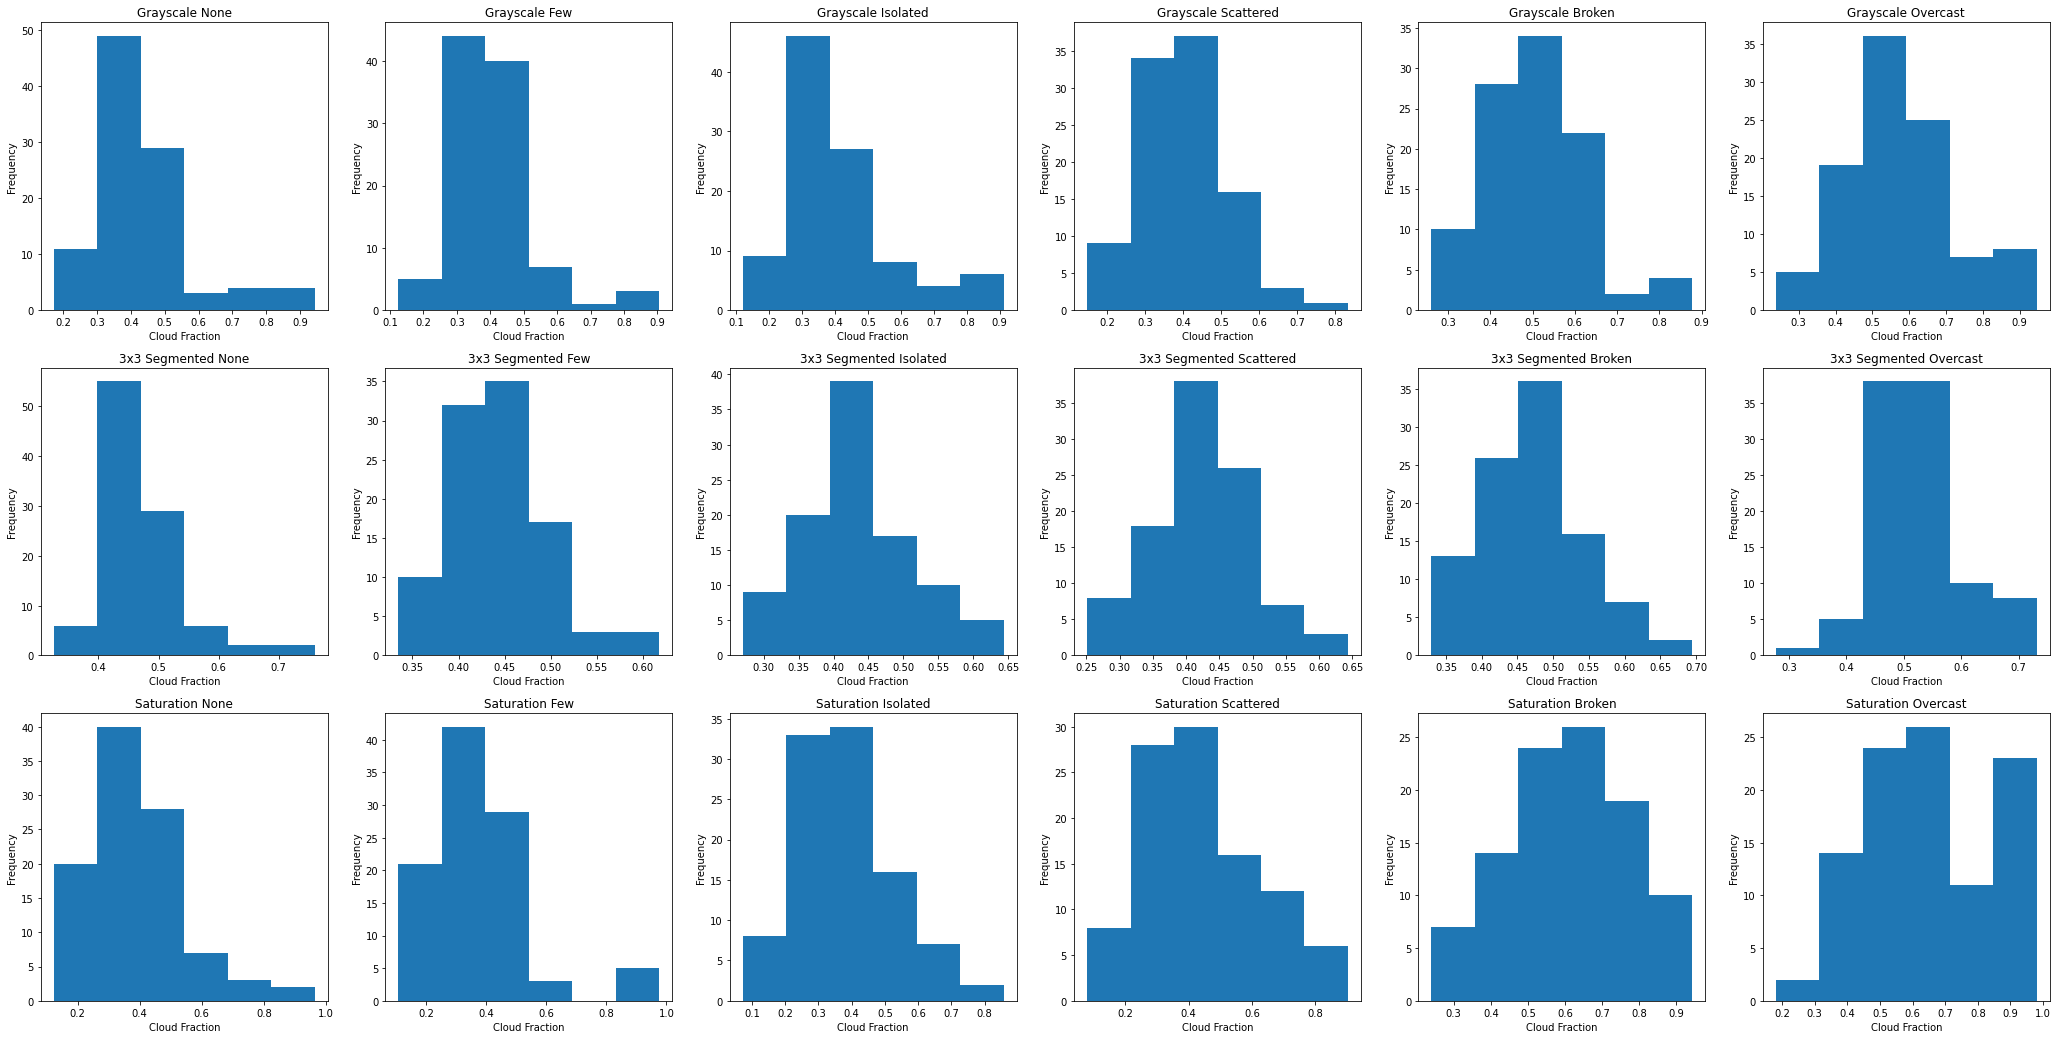

In [ ]:
fig, axs = plt.subplots(3, 6, figsize=(36,18))
r = 0
c = 0
t = 0
for i in range(0,len(composite_data.columns),2):
  d = ((4 * composite_data.iloc[:, i]) + composite_data.iloc[:, i+1]) / 5
  axs[r,c].hist(x=d, bins=6)
  axs[r,c].set_title(titles[t])
  axs[r,c].set(xlabel='Cloud Fraction', ylabel='Frequency')
  c = c + 1
  t = t + 1
  if c == 6:
    r = r + 1
    c = 0

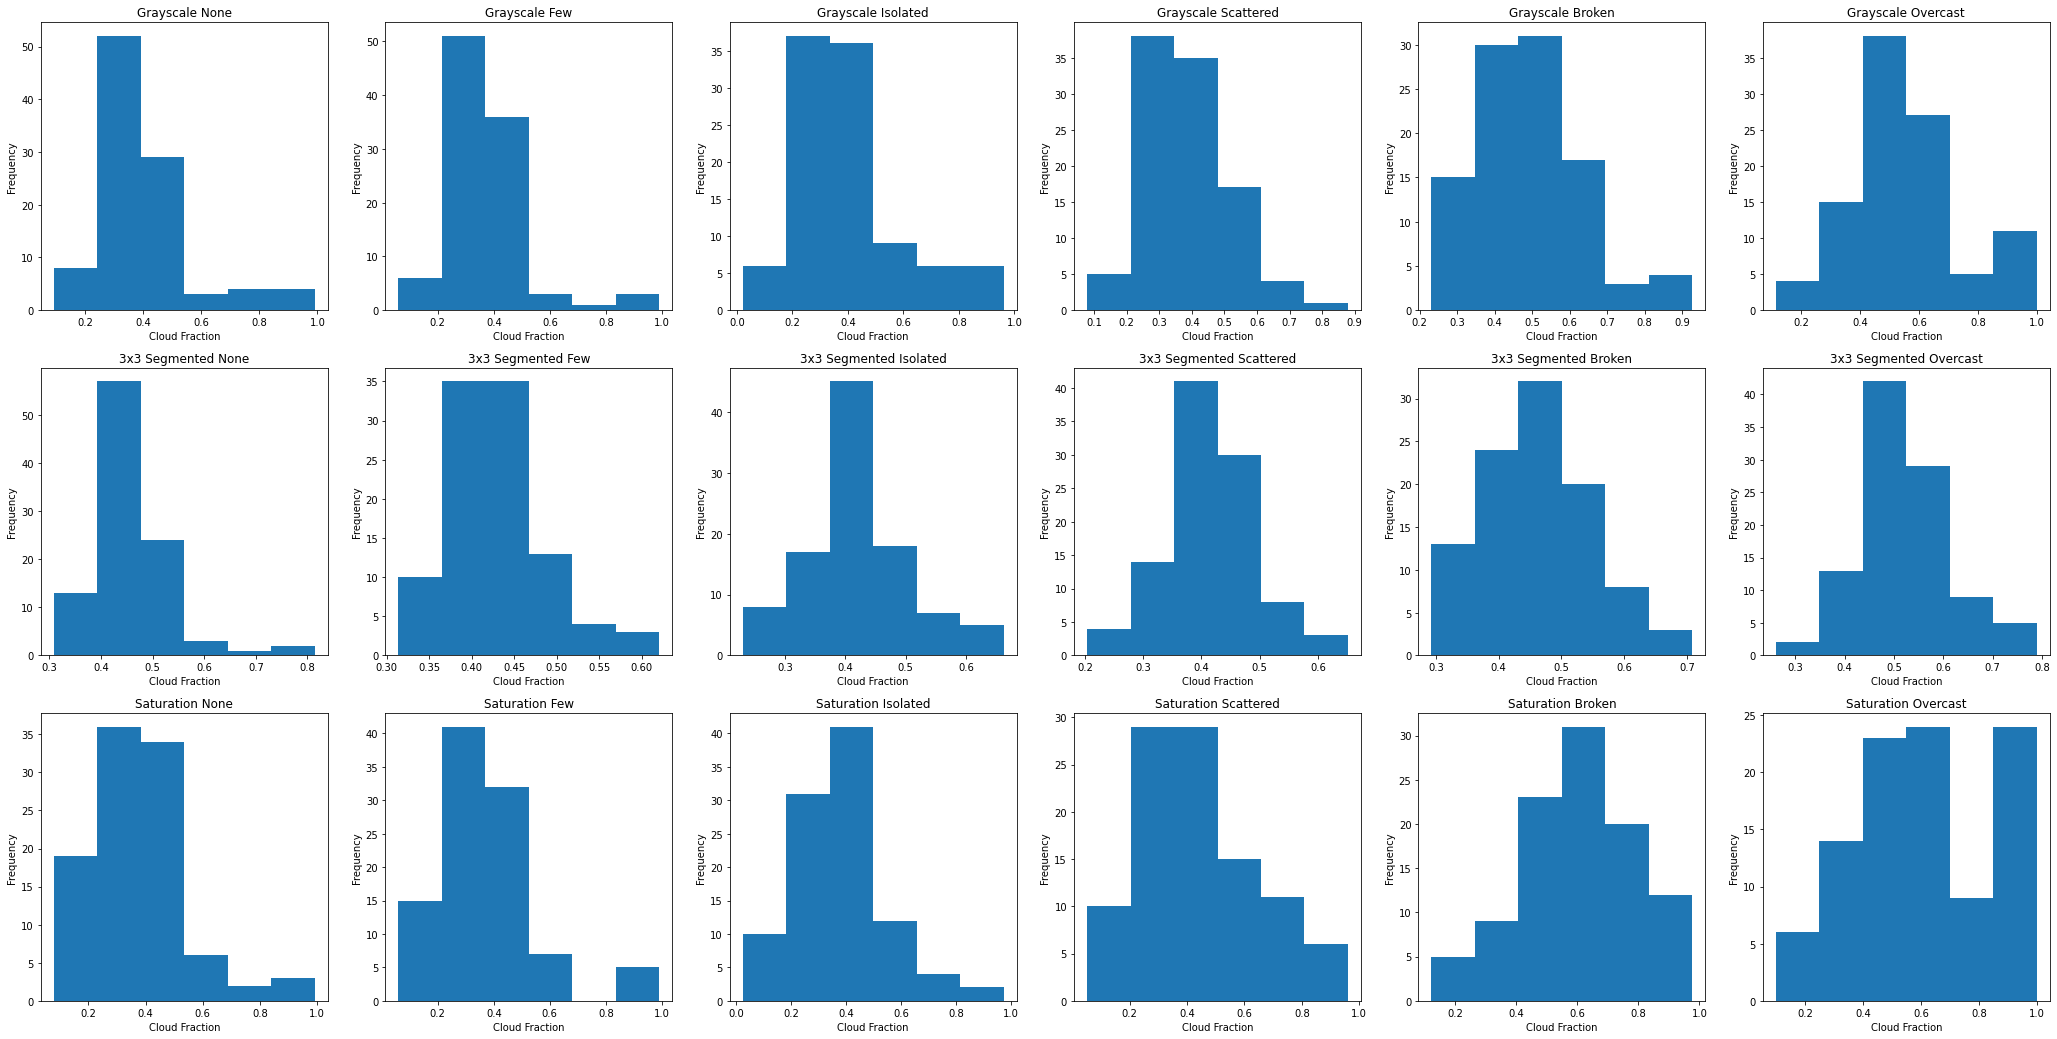

In [ ]:
fig, axs = plt.subplots(3, 6, figsize=(36,18))
r = 0
c = 0
t = 0
for i in range(0,len(composite_data.columns),2):
  d = composite_data.iloc[:, i]
  axs[r,c].hist(x=d, bins=6)
  axs[r,c].set_title(titles[t])
  axs[r,c].set(xlabel='Cloud Fraction', ylabel='Frequency')
  c = c + 1
  t = t + 1
  if c == 6:
    r = r + 1
    c = 0

## Conclusion

We see that the 'none' and 'overcast' are not ideal since their values are spread throughout but the majority should be on the sides. Besides that, most of the distributions seem to be somewhat normally distributed. This might be indicative of something in the thresholding functions or the dataset. In terms of ideal distributions, it seems most of the thresholding techniques worked well on the 'few' category. There is is not that as much variance in terms of the distribution of each category, regardless of thresholding technique.

## Future Directions

* Rerun analysis on more/different samples
* Use more/different thresholding techniques (e.g. multi_otsu)
* Check the observations themselves to see if they match their cloud cover category
* Try a different direction instead of thresholding for image data cleaning.

